In [1]:
from src.data import gedi_pipeline
#from fastai import *
from fastbook import *
from fastai.tabular.all import *
from fastai import *

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import graphviz
import regex as re

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [3]:
def rf(xs, y, n_estimators=50, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

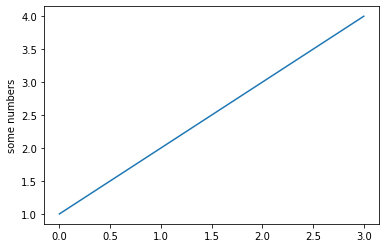

In [2]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

In [4]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
def r_squared(m, xs, y): return r_mse(m.predict(xs), y)

In [5]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [6]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In this notebook, we'd like to see if we can predict carbon in burnt areas. There are two separate goals.

1. Predict burn area carbon with as many features as possible. Then, do variable importance ranking and partial dependence plots.
2. Predict burn area carbon using whatever is available throughout the time range. The purpose of this would be to go back in time, and re-run carbon estimation for these burnt areas, reconstructing recovery.

### Unresolved questions

1. Do we take land cover and pft_class into consideration when doing prediction? Do we use them as features at all?
2. What other variables should be added? Does it make sense to use previous year spectral? How much should that be amplified?
3. Do we do try to predict carbon or log carbon?


### Proposal

Section 1. Predict burn carbon using all variables, including pft_class and land cover. See what happens.

In [7]:
# Load datasets
print('Load training GEDI shots')
gedi_train = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_train.csv", index_col=0)

print('Load validation GEDI shots')
gedi_valid = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_validation.csv", index_col=0)

Load training GEDI shots
Load validation GEDI shots


In [8]:
gedi_train_burned, gedi_train_unburned = gedi_pipeline.filter_shots(gedi_train)
gedi_valid_burned, gedi_valid_unburned = gedi_pipeline.filter_shots(gedi_valid)

2023-05-30 12:29:40,790 DEBUG: Excluded shots on the burn boundaries, shots remaining:         6421929 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:49]
2023-05-30 12:29:40,899 DEBUG: Number of GEDI shots that burned at least once:                  754690 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:54]
2023-05-30 12:29:41,920 DEBUG: Number of GEDI shots that never burned since 1984:         5667239 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:60]
2023-05-30 12:29:42,447 DEBUG: Excluded shots on the burn boundaries, shots remaining:         1140176 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:49]
2023-05-30 12:29:42,467 DEBUG: Number of GEDI shots that burned at least once:                  137848 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:54]
2023-05-30 12:29:42,619 DEBUG: Number of GEDI shots that never burned since 1984:         1002328 [in filter_shots at /home/j

### Part 1 - Analysis 5.30.1

No filtering other than for burn count - let the rest be figured out by the model.

In [9]:
columns_to_keep = ['agbd', 'beam_type', 'sensitivity', 'pft_class', 'gedi_year', 'gedi_month', 'burn_severity_median',
'burn_year_median', 'burn_counts_median', 'elevation', 'slope', 'aspect', 'soil', 'land_cover', 'nbr', 'ndvi',
'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'time_since_burn']

In [10]:
gedi_data_train= gedi_train_burned[columns_to_keep]
gedi_data_valid= gedi_valid_burned[columns_to_keep]

In [11]:
beam_types = 'full', 'coverage'
gedi_data_train['beam_type'] = gedi_data_train['beam_type'].astype('category')
gedi_data_train['beam_type'].cat.set_categories(beam_types, ordered=False, inplace=True)
gedi_data_valid['beam_type'] = gedi_data_valid['beam_type'].astype('category')
gedi_data_valid['beam_type'].cat.set_categories(beam_types, ordered=False, inplace=True)

/tmp/ipykernel_4097298/1011805621.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
/tmp/ipykernel_4097298/1011805621.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [12]:
dep_var = 'agbd'
# Remove any rows where agbd == 0
gedi_data_train = gedi_data_train[gedi_data_train.agbd != 0]
gedi_data_valid= gedi_data_valid[gedi_data_valid.agbd != 0]

In [13]:
# Train on log.
gedi_data_train[dep_var] = np.log(gedi_data_train[dep_var])
gedi_data_valid[dep_var] = np.log(gedi_data_valid[dep_var])

In [14]:
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(gedi_data_train, 1, dep_var=dep_var)
train_data = TabularPandas(gedi_data_train, procs, cat, cont, y_names=dep_var)
valid_data = TabularPandas(gedi_data_valid, procs, cat, cont, y_names=dep_var)

In [16]:
save_pickle(f"/maps/fire-regen/data/rf/train_5.30.1.pkl", train_data)
save_pickle(f"/maps/fire-regen/data/rf/valid_5.30.1.pkl", valid_data)

In [15]:
xs, y = train_data.train.xs, train_data.train.y
valid_xs, valid_y = valid_data.train.xs, valid_data.train.y

In [16]:
m = rf(xs, y)

In [17]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.664118, 0.770085)

In [18]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWar

In [19]:
preds_std = preds.std(0)

In [20]:
preds_analysis = valid_xs.copy()
preds_analysis['pred_std'] = preds_std

In [21]:
preds_analysis['log_agbd'] = valid_y

In [22]:
preds_analysis.sort_values('pred_std', ascending=False, inplace=True)
preds_analysis

,beam_type,sensitivity,pft_class,gedi_year,gedi_month,burn_severity_median,burn_year_median,burn_counts_median,elevation,slope,aspect,soil,land_cover,nbr,ndvi,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,time_since_burn,pred_std,log_agbd
745748,1,0.977603,6,2019,9,2.0,2018.0,1.0,1279,0,308,0,1,0.359526,0.367574,8066.066895,8226.500000,9466.200195,9112.400391,19704.900391,11207.700195,9283.000000,1.0,1.868484,0.806822
468955,1,0.979026,6,2020,12,2.0,2014.0,1.0,1307,0,180,0,4,0.081663,0.114220,8020.250000,8634.000000,9739.625000,10399.500000,13081.500000,12723.875000,11106.250000,6.0,1.768973,0.021935
682281,1,0.975760,6,2019,11,1.0,2016.0,1.0,2010,1,180,0,5,0.122590,0.238222,7799.571289,8726.181641,9939.181641,10733.000000,17445.818359,17587.636719,13635.545898,3.0,1.761271,-0.030098
682572,1,0.974126,6,2021,2,2.0,2016.0,2.0,1985,1,281,0,4,0.120682,0.242079,8223.266602,8666.599609,9790.200195,10268.666992,16828.267578,15860.599609,13203.933594,5.0,1.749144,1.929288
682260,1,0.970073,6,2019,9,1.5,2016.0,1.0,1971,1,230,0,5,-0.027587,0.093304,8225.066406,8660.099609,9536.700195,10028.099609,12092.000000,13749.700195,12778.099609,3.0,1.740282,3.658994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410749,1,0.950047,1,2020,8,2.0,1987.0,1.0,1119,1,345,0,5,0.060650,0.154580,8519.125000,8809.250000,9475.500000,9863.250000,13470.125000,13711.625000,11929.625000,33.0,0.034213,2.665946
410751,1,0.956122,1,2020,8,2.0,1987.0,1.0,1116,1,332,0,5,0.081188,0.168016,8384.625000,8684.875000,9396.625000,9726.000000,13654.250000,13399.250000,11603.625000,33.0,0.033928,2.716041
410773,1,0.959798,1,2020,8,2.5,1987.0,1.0,1124,1,345,0,5,0.073094,0.164005,8413.375000,8649.125000,9264.625000,9551.500000,13299.125000,13158.750000,11487.375000,33.0,0.031449,2.753362
410663,1,0.953273,1,2019,10,2.0,1987.0,1.0,1113,0,232,0,5,0.082739,0.171265,8333.713867,8667.833008,9287.833008,9598.000000,13565.000000,13367.833008,11491.833008,32.0,0.030184,2.689327


In [23]:
preds_analysis.head(100)

,beam_type,sensitivity,pft_class,gedi_year,gedi_month,burn_severity_median,burn_year_median,burn_counts_median,elevation,slope,aspect,soil,land_cover,nbr,ndvi,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,time_since_burn,pred_std,log_agbd
745748,1,0.977603,6,2019,9,2.0,2018.0,1.0,1279,0,308,0,1,0.359526,0.367574,8066.066895,8226.500000,9466.200195,9112.400391,19704.900391,11207.700195,9283.000000,1.0,1.868484,0.806822
468955,1,0.979026,6,2020,12,2.0,2014.0,1.0,1307,0,180,0,4,0.081663,0.114220,8020.250000,8634.000000,9739.625000,10399.500000,13081.500000,12723.875000,11106.250000,6.0,1.768973,0.021935
682281,1,0.975760,6,2019,11,1.0,2016.0,1.0,2010,1,180,0,5,0.122590,0.238222,7799.571289,8726.181641,9939.181641,10733.000000,17445.818359,17587.636719,13635.545898,3.0,1.761271,-0.030098
682572,1,0.974126,6,2021,2,2.0,2016.0,2.0,1985,1,281,0,4,0.120682,0.242079,8223.266602,8666.599609,9790.200195,10268.666992,16828.267578,15860.599609,13203.933594,5.0,1.749144,1.929288
682260,1,0.970073,6,2019,9,1.5,2016.0,1.0,1971,1,230,0,5,-0.027587,0.093304,8225.066406,8660.099609,9536.700195,10028.099609,12092.000000,13749.700195,12778.099609,3.0,1.740282,3.658994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694657,1,0.976011,6,2022,11,2.0,2012.0,2.0,1759,5,168,0,5,0.025347,0.167956,8620.833008,9044.666992,9984.666992,10146.500000,14242.833008,14479.333008,13538.666992,10.0,1.525335,0.330472
1130482,1,0.961186,6,2020,2,2.0,2012.0,1.0,1689,1,146,0,5,0.023391,0.155587,8546.142578,8814.857422,9545.000000,10143.571289,13881.571289,15672.428711,13247.000000,8.0,1.525323,2.884527
349577,1,0.973006,6,2022,9,3.0,2007.0,1.0,1982,5,132,5,1,0.152142,0.249024,8470.922852,8772.615234,9625.615234,9718.000000,16163.000000,14606.307617,11894.307617,15.0,1.523747,3.219355
1063255,1,0.958857,6,2019,8,2.5,2016.0,1.0,2475,7,258,0,5,0.027873,0.142271,8952.125000,9451.500000,10157.250000,10657.500000,14193.000000,15596.500000,13423.250000,3.0,1.522736,4.314043


In [24]:
preds_analysis.tail(100)

,beam_type,sensitivity,pft_class,gedi_year,gedi_month,burn_severity_median,burn_year_median,burn_counts_median,elevation,slope,aspect,soil,land_cover,nbr,ndvi,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,time_since_burn,pred_std,log_agbd
428058,1,0.961834,1,2021,1,2.0,1998.0,1.0,474,1,156,0,5,-0.014059,0.105530,8786.833008,9289.166992,10312.000000,11257.916992,13914.333008,17129.000000,14311.166992,23.0,0.105336,2.652746
415991,1,0.964788,1,2019,10,4.0,2014.0,1.0,1391,7,279,5,5,0.026762,0.140057,9651.833008,9541.666992,10514.500000,11568.666992,15337.000000,17451.500000,14537.500000,5.0,0.104770,2.898225
410760,1,0.957843,1,2020,8,2.0,1987.0,1.0,1119,2,263,0,5,0.063529,0.147054,8636.875000,9002.750000,9875.750000,10429.500000,14025.750000,14191.500000,12350.125000,33.0,0.104297,2.656276
154564,1,0.950710,1,2021,1,2.0,1999.0,1.0,216,1,180,0,5,-0.017159,0.113630,8816.615234,9329.000000,10397.230469,11060.845703,13896.769531,17353.460938,14382.000000,22.0,0.103981,2.838851
468300,1,0.956083,1,2019,11,4.0,2014.0,1.0,1315,4,85,0,5,0.008639,0.155670,8990.142578,9210.166992,10059.666992,11081.833008,15168.166992,17630.833984,14908.333008,5.0,0.103964,2.716763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410749,1,0.950047,1,2020,8,2.0,1987.0,1.0,1119,1,345,0,5,0.060650,0.154580,8519.125000,8809.250000,9475.500000,9863.250000,13470.125000,13711.625000,11929.625000,33.0,0.034213,2.665946
410751,1,0.956122,1,2020,8,2.0,1987.0,1.0,1116,1,332,0,5,0.081188,0.168016,8384.625000,8684.875000,9396.625000,9726.000000,13654.250000,13399.250000,11603.625000,33.0,0.033928,2.716041
410773,1,0.959798,1,2020,8,2.5,1987.0,1.0,1124,1,345,0,5,0.073094,0.164005,8413.375000,8649.125000,9264.625000,9551.500000,13299.125000,13158.750000,11487.375000,33.0,0.031449,2.753362
410663,1,0.953273,1,2019,10,2.0,1987.0,1.0,1113,0,232,0,5,0.082739,0.171265,8333.713867,8667.833008,9287.833008,9598.000000,13565.000000,13367.833008,11491.833008,32.0,0.030184,2.689327


In [25]:
row = preds_analysis.head(100)

In [26]:
prediction,bias,contributions = treeinterpreter.predict(m, row.drop(columns=['pred_std', 'log_agbd']).values)

<module 'matplotlib.pyplot' from '/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/matplotlib/pyplot.py'>

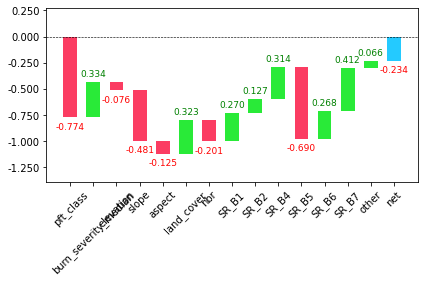

In [30]:
waterfall(valid_xs.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}')

In [32]:
valid_xs.iloc[0]

beam_type                   2.000000
sensitivity                 0.979113
pft_class                   1.000000
gedi_year                2019.000000
gedi_month                  9.000000
burn_severity_median        3.000000
burn_year_median         2018.000000
burn_counts_median          1.000000
elevation                1730.000000
slope                      19.000000
aspect                    180.000000
soil                        5.000000
land_cover                  1.000000
nbr                         0.310630
ndvi                        0.345568
SR_B1                    7661.799805
SR_B2                    8135.166504
SR_B3                    9068.416992
SR_B4                    8759.333008
SR_B5                   18009.916016
SR_B6                   11733.416992
SR_B7                    9472.916992
time_since_burn             1.000000
Name: 1718, dtype: float32

In [33]:
valid_xs.columns, contributions[0]

(Index(['beam_type', 'sensitivity', 'pft_class', 'gedi_year', 'gedi_month',
        'burn_severity_median', 'burn_year_median', 'burn_counts_median',
        'elevation', 'slope', 'aspect', 'soil', 'land_cover', 'nbr', 'ndvi',
        'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7',
        'time_since_burn'],
       dtype='object'),
 array([-0.00340452,  0.04344435, -0.77379298,  0.03799368,  0.00955391,  0.33364627, -0.03596794,  0.0031045 , -0.07617736, -0.48097621, -0.12547435,  0.05894493,  0.32250505, -0.20078507,
        -0.03782286,  0.27045305,  0.12744223,  0.0085133 ,  0.31387944, -0.69037607,  0.2679148 ,  0.4119011 , -0.01872413]))

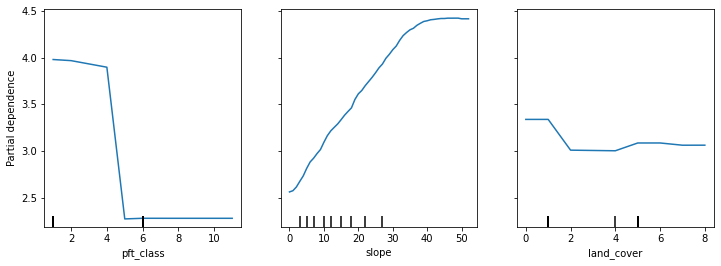

In [45]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, valid_xs, ['pft_class','slope', 'land_cover'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

In [34]:
fi = rf_feat_importance(m, xs)

<AxesSubplot: ylabel='cols'>

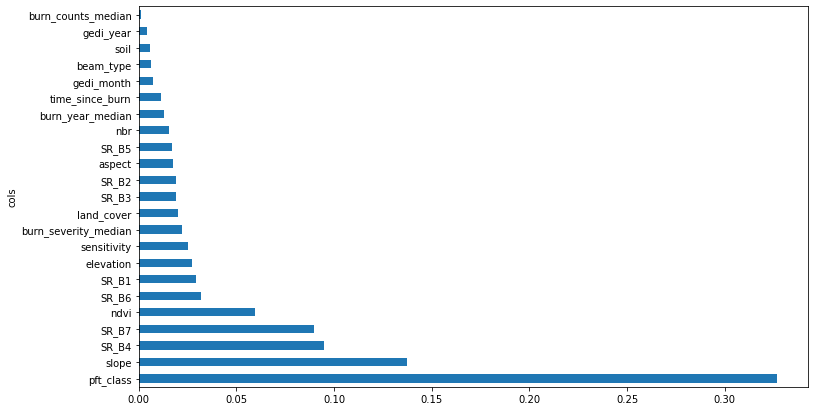

In [35]:
plot_fi(fi[:30])

### Part 2 - Analysis 5.30.2

Filter for trees only - according to pft_class. Also, only full beam.

In [66]:
gedi_data_train= gedi_train_burned[(gedi_train_burned.pft_class == 1) & (gedi_train_burned.beam_type == "full")]
gedi_data_valid= gedi_valid_burned[(gedi_valid_burned.pft_class == 1) & (gedi_valid_burned.beam_type == "full")]

In [67]:
# Look at those that only burned once
gedi_data_train= gedi_pipeline.filter_shots_for_regrowth_analysis(gedi_data_train)
gedi_data_valid= gedi_pipeline.filter_shots_for_regrowth_analysis(gedi_data_valid)
gedi_data_train.shape[0], gedi_data_valid.shape[0]

2023-05-30 12:50:36,551 DEBUG: Number of shots that happened after fires:                    265364 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:77]
2023-05-30 12:50:36,691 DEBUG: Number of shots that burned exactly once:                    236236 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:82]
2023-05-30 12:50:36,827 DEBUG: Number of shots that burned in 2-4 categories:                    194757 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:87]
2023-05-30 12:50:36,877 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    128702 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:91]
2023-05-30 12:50:36,924 DEBUG: Number of shots that happened after fires:                    49850 [in filter_shots_for_regrowth_analysi

(128702, 25843)

In [65]:
columns_to_keep = ['agbd', 'gedi_year', 'gedi_month', 'burn_severity_median',
'elevation', 'slope', 'aspect', 'soil', 'land_cover', 'nbr', 'ndvi',
'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'time_since_burn']

In [68]:
gedi_data_train= gedi_data_train[columns_to_keep]
gedi_data_valid= gedi_data_valid[columns_to_keep]

In [69]:
dep_var = 'agbd'
# Remove any rows where agbd == 0
gedi_data_train = gedi_data_train[gedi_data_train.agbd != 0]
gedi_data_valid= gedi_data_valid[gedi_data_valid.agbd != 0]

In [70]:
# Train on log.
gedi_data_train[dep_var] = np.log(gedi_data_train[dep_var])
gedi_data_valid[dep_var] = np.log(gedi_data_valid[dep_var])

In [71]:
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(gedi_data_train, 1, dep_var=dep_var)
train_data = TabularPandas(gedi_data_train, procs, cat, cont, y_names=dep_var)
valid_data = TabularPandas(gedi_data_valid, procs, cat, cont, y_names=dep_var)

In [72]:
save_pickle(f"/maps/fire-regen/data/rf/train_5.30.2.pkl", train_data)
save_pickle(f"/maps/fire-regen/data/rf/valid_5.30.2.pkl", valid_data)

In [73]:
xs, y = train_data.train.xs, train_data.train.y
valid_xs, valid_y = valid_data.train.xs, valid_data.train.y

In [74]:
# TODO: use OOB predictor
m = rf(xs, y, max_samples=100000)

In [75]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.436773, 0.636015)

In [76]:
fi = rf_feat_importance(m, xs)

<AxesSubplot: ylabel='cols'>

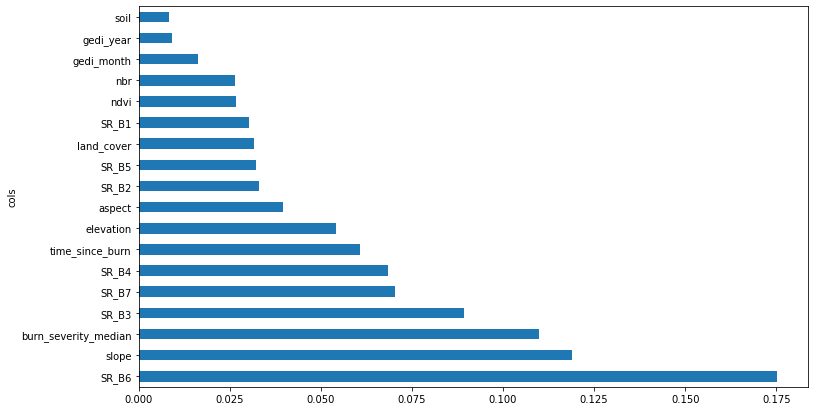

In [77]:
plot_fi(fi[:30])

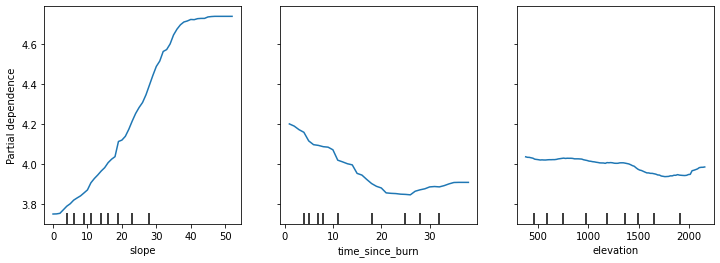

In [85]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, valid_xs, ['slope', 'time_since_burn', 'elevation'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

### Part 3 - 5.30.3 - Predicting rel agbd, rather than raw

But first, I have to calculate rel-agbd for the new data. Gah!

In [94]:
import importlib
importlib.reload(gedi_pipeline)
from src.data import k_nn

2023-05-30 13:58:06,421 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [86]:
# Load datasets
print('Load training GEDI shots')
gedi_train = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_train.csv", index_col=0)

print('Load validation GEDI shots')
gedi_valid = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_validation.csv", index_col=0)

print('Load test GEDI shots')
gedi_test = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_test.csv", index_col=0)

# We're actually going to combine all three here in order to properly calculate knn, then we'll put them back together.

Load training GEDI shots
Load validation GEDI shots
Load test GEDI shots


In [87]:
gedi = pd.concat([gedi_train, gedi_valid, gedi_test])

In [92]:
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_df_for_regrowth_analysis(gedi, trees=False)

2023-05-30 13:56:47,673 DEBUG: Total number of GEDI shots available for the region:         8918782 [in process_gedi_df_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:144]
2023-05-30 13:56:53,397 DEBUG: Excluded shots on the burn boundaries, shots remaining:         8918782 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:56]
2023-05-30 13:56:53,707 DEBUG: Number of GEDI shots that burned at least once:                  1045416 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:61]
2023-05-30 13:56:55,978 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:67]
2023-05-30 13:56:56,945 DEBUG: Number of shots that happened after fires:                    1045416 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:84]
2023-05-30 13:56:57,249 DEBUG: Number of shots that burned exactly once:         

In [93]:
gedi_burned_trees = gedi_burned[gedi_burned.land_cover==1]
gedi_unburned_trees = gedi_unburned[gedi_unburned.land_cover==1]

In [95]:
nn_indeces, nn_distances, nn_avg_agbd = k_nn.nearest_neighbors(gedi_burned_trees, gedi_unburned_trees, 'agbd', 200)

In [96]:
gedi_burned_trees['rel_agbd'] = gedi_burned_trees.agbd / nn_avg_agbd
gedi_burned_trees['nn_avg_agbd'] = nn_avg_agbd
gedi_burned_trees['nn_index'] = range(0, nn_distances.shape[0])

In [165]:
gedi_data_train= gedi_burned_trees[(gedi_burned_trees.pft_class == 1) & (gedi_burned_trees.beam_type == "full")]

In [166]:
gedi_data_train = gedi_data_train[(gedi_data_train.gedi_month >4) & (gedi_data_train.gedi_month<11)]

In [139]:
gedi_data_train.shape[0]

66692

In [167]:
gedi_data_train = gedi_data_train[gedi_data_train.burn_severity_median == 4]

In [168]:
columns_to_keep = ['rel_agbd', 'gedi_year', 'gedi_month',
'elevation', 'slope', 'aspect', 'soil', 'land_cover', 'nbr', 'ndvi',
'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'time_since_burn']

In [169]:
gedi_data_train= gedi_data_train[columns_to_keep]

In [170]:
dep_var = 'rel_agbd'
# Remove any rows where agbd == 0
#gedi_data_train = gedi_data_train[gedi_data_train.rel_agbd != 0]

In [171]:
gedi_data_train[dep_var] = np.log(gedi_data_train[dep_var])

In [172]:
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(gedi_data_train, 1, dep_var=dep_var)
train_data = TabularPandas(gedi_data_train, procs, cat, cont, y_names=dep_var)

In [173]:
xs, y = train_data.train.xs, train_data.train.y

In [174]:
m = rf(xs, y, max_samples=6000)

In [175]:
m_rmse(m, xs, y)

0.543208

In [176]:
fi = rf_feat_importance(m, xs)

<AxesSubplot: ylabel='cols'>

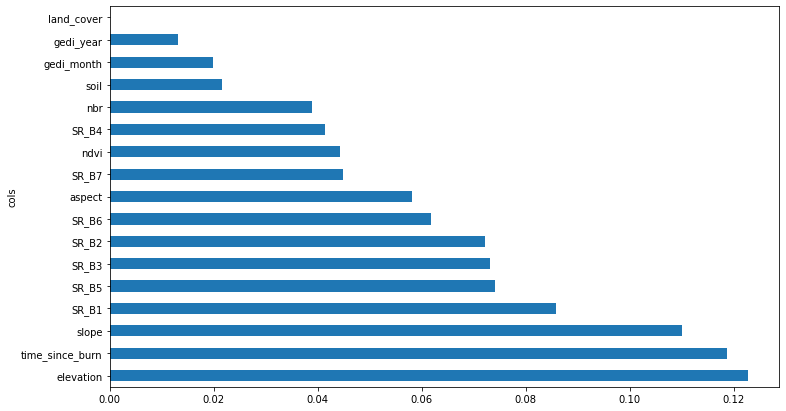

In [177]:
plot_fi(fi[:30])

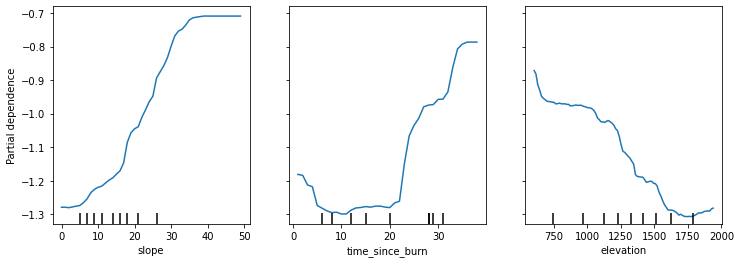

In [178]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['slope', 'time_since_burn', 'elevation'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

In [181]:
np.exp(np.log(0.5) - 0.5)

0.3032653298563167